 # Linear Regression - Ridge Regression
 -------------------------

 This project is adapted from Columbia Engineering | Emeritus' course Applied Machine Learning

 ## Project Guide

 --------------------
 - [Project Overview](#overview)
 - [Data Review](#data)
 - [Coding Ridge Regression](#code)
 - [Ridge Regression in `sklearn`](#sklearn)

 <a id = "overview"></a>
 ## Project Overview
 -------------

 This project builds a version of ridge-regularized regression in `Python`.

 In writing Ridge Regression, we:
 - Mean center target variable and mean center / standardize observation
 - Calculate Ridge Regression weights using linear algebra
 - Create a  hyperparameter tuning process

 **Motivation**: Ridge Regression offers a way to mitigate some of the weaknesses of Least Squares Linear Regression to build more robust models.

 **Objectives**:

 - Demonstrate mathematical understandings of Ridge Regression
 - Introduce the concept of hyper-parameter tuning

 **Problem**: Using housing data, we will attempt to predict house price using living area with a regression model.

 **Data**: [Kaggle's House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).


 <a id = "data"></a>
 ### Data Exploration

 Below provides a review of the "Housing" dataset.

In [15]:
### This cell imports the necessary modules and sets a few plotting parameters for display

#get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)  

### Read in the data and display the first few lines
tr_path = './train.csv'
test_path = './test.csv'

data = pd.read_csv(tr_path)  

data.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


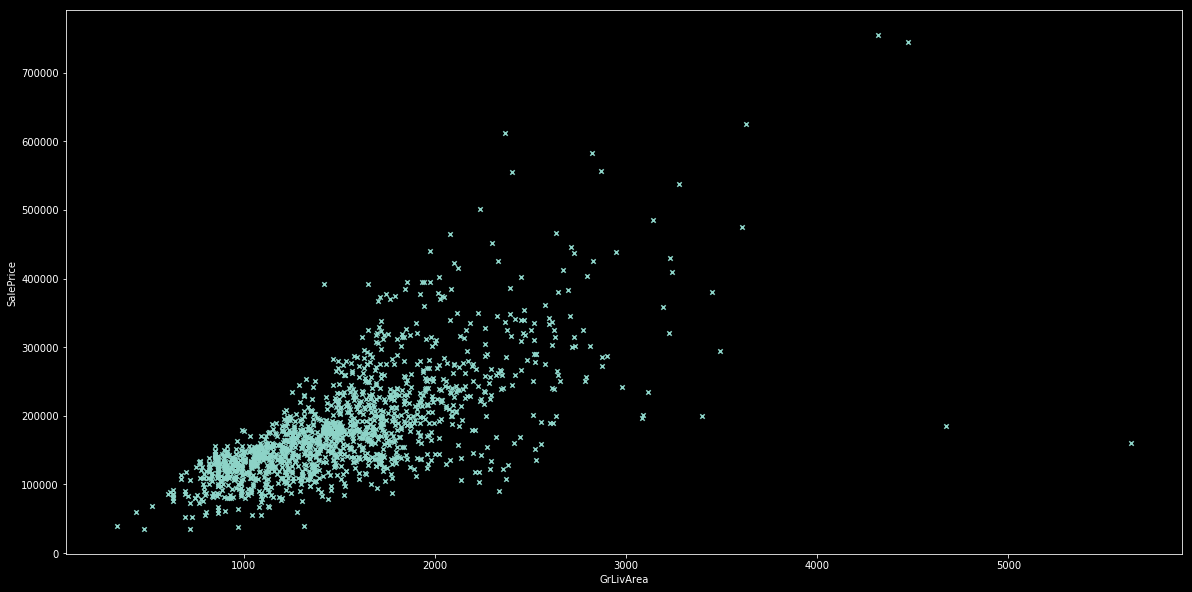

In [16]:
# Plot living area vs sale price
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'x');



 <a id = "code"></a>
 ### Ridge Regression

 #### Preprocessing
 Before implementing Ridge Regression, it is important to mean-center our target variable and mean-center and standardize observations. We do this according to the following:
 #### Mean Center Target
 $$y_{cent} = y_0 - \bar{y}$$

 #### Standardize Observations
 $$X_{std} = \frac{X_0-\bar{X}}{s_{X}}$$

 Where $\bar{X}$ is the sample mean of X and $s_{X}$ is the sample standard deviation of X


In [17]:
### Define a function to return a "standardized" list of inputs for ridge regression
def standardize( num_list):
    import numpy as np
    """
    Standardize the given list of numbers
    
    Positional arguments:
        num_list -- a list of numbers
    
    """
    
    x_bar = np.mean(num_list)
    x_std = np.std(num_list)
    std_list = (num_list - x_bar) / x_std
    
    return std_list


 Below we create a preprocessing function which performs:
 * mean subtraction from $y$,
 * dimension standardization for $x$.

In [18]:
def preprocess_for_regularization(data, y_column_name, x_column_names):
    """
    Perform mean subtraction and dimension standardization on data
        
    Positional argument:
        data -- a pandas dataframe of the data to pre-process
        y_column_name -- the name (string) of the column that contains
            the target of the training data.
        x_column_names -- a *list* of the names of columns that contain the
            observations to be standardized
        
    Returns:
        Return a DataFrame consisting only of the columns included
        in `y_column_name` and `x_column_names`.
        Where the y_column has been mean-centered, and the
        x_columns have been mean-centered/standardized.
    """
  
    prepro_data = pd.DataFrame()
    
    for col in x_column_names:
        col_bar = np.mean(data[col])
        col_std = np.std(data[col])
        prepro_data[col] = data[col].apply(lambda x: (x - col_bar) / col_std)
        
    y_bar = np.mean(data[y_column_name])
    prepro_data[y_column_name] = data[y_column_name].apply(lambda y: y - y_bar)
    
    return prepro_data



 Next, we implement the equation for ridge regression using the closed form equation:

 $$w_{RR}=(\lambda+X^TX)^{-1}X^Ty$$

 The main change from Least Squares Regression is that $\lambda$ is a parameter *we* must set.

In [19]:
### Define a function "ridge_regression_weights"
### ACCEPT three inputs: Two matricies corresponding to the x inputs and y target and a number (int or float) for the lambda parameter
### RETURN a numpy array of regression weights


def ridge_regression_weights(input_x, output_y, lambda_param):
    """Calculate ridge regression least squares weights.
    
    Positional arguments:
        input_x -- 2-d matrix of input data
        output_y -- 1-d numpy array of target values
        lambda_param -- lambda parameter that controls how heavily
            to penalize large weight values
        
    Assumptions:
        -- output_y is a vector whose length is the same as the number of observations in input_x
        -- lambda_param has a value greater than 0
    """
    #Ensure the number of rows of each the X matrix is greater than the number of columns.
    #If not, transpose the matrix.
    if input_x.shape[0] < input_x.shape[1]:
        input_x = np.transpose(input_x)

    # Prepend ones to x matrix
    ones = np.ones((len(output_y), 1), dtype=int)
    augmented_x = np.concatenate((ones, input_x), axis=1)
    
    # Create Lambda matrix
    lambda_matrix = np.identity(augmented_x.shape[1]) * lambda_param
        
    left_multiplier = np.matmul(np.linalg.inv(lambda_matrix + np.matmul(np.transpose(augmented_x), augmented_x)), np.transpose(augmented_x))
    w_rr = np.matmul(left_multiplier, output_y)
    
    return w_rr



 #### Selecting the $\lambda$ parameter

 Create a hyper-parameter tuning algorithm.

 In ridge regression, we must pick a value for $\lambda$. We have some intuition about $\lambda$ from the equations that define it: small values tend to emulate the results from Least Squares, while large values will reduce the dimensionality of the problem. But the choice of $\lambda$ can motivated with a more precise quantitative treatment.

 Eventually, we choose the value of $\lambda$ that minimizes validation error, which we will determine using $k$-fold cross-validation.

 For this example here, we will solve a simpler but more problem: Find a value that minimizes the mean of the list returned by a function.

In [20]:
### `hidden` takes a single number as a parameter (int or float) and returns a list of 1000 numbers
### the input must be between 0 and 50 exclusive

def hidden(hp):
    if (hp<=0) or (hp >= 50):
        print("input out of bounds")
    
    nums = np.logspace(0,5,num = 1000)
    
    #This is the number we should approximate in the minimize function defined below
    vals = nums** 43.123985172351235134687934
    
    user_vals = nums** hp
    
    return vals-user_vals


In [21]:
### Define a function called "minimize"
### ACCEPT one input: a function.

### This function is similar to `hidden` created above 
### Like 'hidden', the passed function will take a single argument, a number between 0 and 50 exclusive 
### and then, the function will return a numpy array of 1000 numbers.

### RETURN the value that makes the mean of the array returned by 'passed_func' as close to 0 as possible

def minimize( passed_func):
    """
    Find the numeric value that makes the mean of the
    output array returned from 'passed_func' as close to 0 as possible.
    
    Positional Argument:
        passed_func -- a function that takes a single number (between 0 and 50 exclusive)
            as input, and returns a list of 1000 floats.
        
    return float()
    """

    #Generate the lambda series    
    lambda_indices = np.arange(1,49,0.01)
    lambda_array_val = pd.Series(index=lambda_indices)

    #Get the mean for each item in the series
    for x in lambda_indices:
        lambda_array_val[x] = abs(np.mean(passed_func(x)))

    #Return the index value that produces the minimum mean (argmin)
    return lambda_array_val.idxmin()

minimize(hidden)



43.12000000000004

 The above simulates hyper parameter tuning.

 In the case of ridge regression, we search lambda parameters to minimize validation error.

 The `hidden` function is analogous to the model building; the returned list analogous to residuals; and the mean of that list analogous to validation error.

 Below is an example of using the functions built above that automatically performs hyper-parameter tuning using mean-absolute-deviation.

In [22]:
def lambda_search_func(lambda_param):
    
    # Define X and y
    # with preprocessing
    df = preprocess_for_regularization(data.head(50),'SalePrice', ['GrLivArea','YearBuilt'])
    
    y_true = df['SalePrice'].values
    X = df[['GrLivArea','YearBuilt']].values
    
    # Calculate Weights then use for predictions
    weights = ridge_regression_weights(X, y_true, lambda_param )
    y_pred = weights[0] + np.matmul(X,weights[1:])
    
    # Calculate Residuals
    resid = y_true - y_pred
    
    # take absolute value to tune on mean-absolute-deviation
    # Alternatively, could use:
    # return resid **2-S
    # for tuning on mean-squared-error
    
    return abs(resid)

minimize(lambda_search_func)


2.9300000000000015

 <a id = "sklearn"></a>
 ### Ridge Regression in `sklearn`

 Below implements ridge regression in sklearn.

In [23]:
from sklearn.linear_model import Ridge, LinearRegression

### Note, the "alpha" parameter defines regularization strength.
### Lambda is a reserved word in `Python` -- Thus "alpha" instead

### An alpha of 0 is equivalent to least-squares regression
lr = LinearRegression()
reg = Ridge(alpha = 100000)
reg0 = Ridge(alpha = 0)

# Notice how the consistent sklearn syntax may be used to easily fit many kinds of models
for m, name in zip([lr, reg, reg0], ["LeastSquares","Ridge alpha = 100000","Ridge, alpha = 0"]):
    
    m.fit(data[['GrLivArea','YearBuilt']], data['SalePrice'])
    print(name, "Intercept:", m.intercept_, "Coefs:",m.coef_,"\n")


LeastSquares Intercept: -2024976.362585636 Coefs: [  95.16733349 1045.86241944] 

Ridge alpha = 100000 Intercept: -1876820.7548806793 Coefs: [ 96.01060155 970.05661101] 

Ridge, alpha = 0 Intercept: -2024976.3625856352 Coefs: [  95.16733349 1045.86241944] 



 Note, in the above example, an alpha of 100,000 is set for the ridge regularization. The reason an alpha value this high is required is because standardization / mean centering of our inputs did not occur, and instead of working with inputs on the order of [-4,4] we are on the interval of [0,2000].